In [10]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.saving import load_model
from matplotlib import rcParams
from sklearn.metrics import (
                             accuracy_score,
                             confusion_matrix,
                             f1_score,
                             precision_score,
                             recall_score,
                             roc_auc_score,
)

from src.utils import colors

In [4]:
# set font family to Lato-Regular
rcParams["font.size"] = 14
sns.set_style("whitegrid")

In [5]:
path = os.path.join("..", "data", "results")

In [6]:
models = ["cnn", "lstm", "cnn_lstm", "cnn_lstm_attention"]
histories = [
    json.load(open(os.path.join(path, f"{model}_training_results_15.json")))
    for model in models
]

In [24]:
linestyles = ["-", "--", "-.", ":"]


def plot_training_history(loss_or_acc, histories, name=""):
    N = len(histories[0][loss_or_acc])

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    for i, (model, history) in enumerate(zip(models, histories)):
        idx = i + 1 if i < 3 else i+2
        ax[0].plot(history[loss_or_acc], label=model, linestyle=linestyles[i], c=colors[idx], linewidth=2)

    ax[0].set_title("Training set")
    ax[0].set_xlabel("Epoch")
    ax[0].set_xticks(np.arange(N), np.arange(1, N + 1))
    ax[0].set_ylabel(loss_or_acc.capitalize())
    ax[0].legend()

    for i, (model, history) in enumerate(zip(models, histories)):
        idx = i + 1 if i < 3 else i+2
        ax[1].plot(history[f"val_{loss_or_acc}"], label=model, linestyle=linestyles[i], c=colors[idx], linewidth=2)
    ax[1].set_title("Validation set")
    ax[1].set_xlabel("Epoch")
    ax[1].set_xticks(np.arange(N), np.arange(1, N + 1))
    ax[1].set_ylabel(loss_or_acc.capitalize())
    ax[1].legend()
    plt.tight_layout()
    plt.savefig(
        os.path.join("..", "figures", f"{loss_or_acc}_training_results{name}.pdf")
    )
    plt.show()

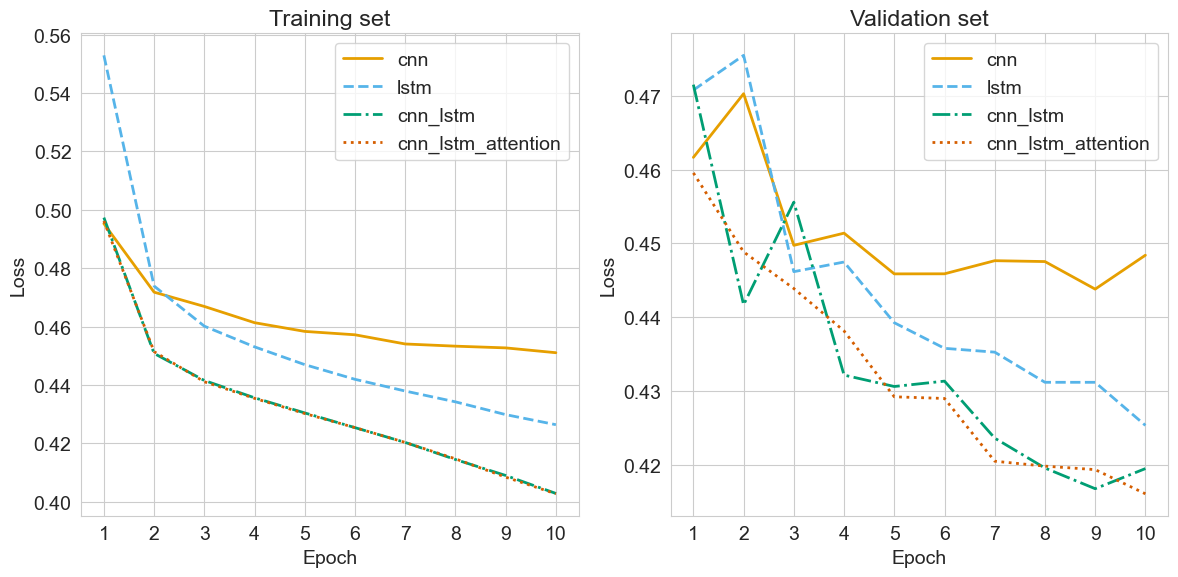

In [25]:
plot_training_history("loss", histories)

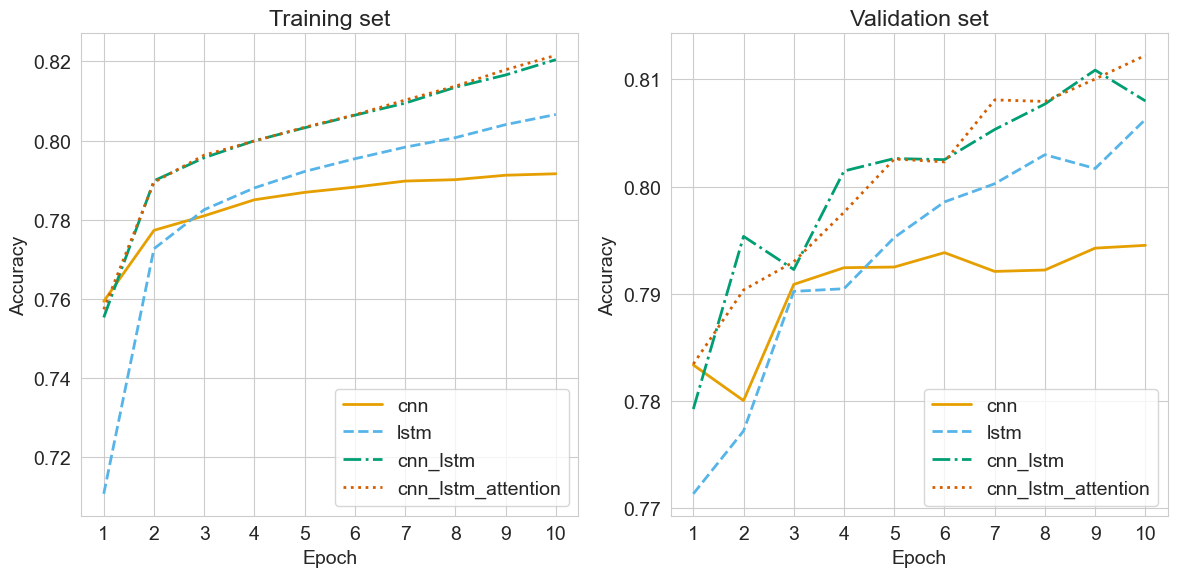

In [26]:
plot_training_history("accuracy", histories)

In [27]:
models_networks = [
    load_model(os.path.join("..", "models", f"{model}_15.keras")) for model in models
]


Instructions for updating:
Use fn_output_signature instead


In [10]:
def get_model_summary_table(models, models_names):
    df = pd.DataFrame(
        np.zeros((len(models), 3)),
        columns=["Model", "Number of layers", "Number of parameters"],
    ).astype({"Model": "str", "Number of layers": "int", "Number of parameters": "int"})
    for i, model in enumerate(models):
        num_layers = int(len(model.layers))
        num_params = int(model.count_params())
        df.loc[i] = [models_names[i], num_layers, num_params]
    return df

In [11]:
print(get_model_summary_table(models_networks, models).to_latex())

\begin{tabular}{llrr}
\toprule
 & Model & Number of layers & Number of parameters \\
\midrule
0 & cnn & 10 & 156879 \\
1 & lstm & 11 & 133135 \\
2 & cnn_lstm & 13 & 190415 \\
3 & cnn_lstm_attention & 15 & 194640 \\
\bottomrule
\end{tabular}



In [28]:
test_X = np.load(os.path.join("..", "data", "classifier", "15", "test", "X_test.npy"))
test_y = np.load(os.path.join("..", "data", "classifier", "15", "test", "y_test.npy"))
test_labels = np.load(
    os.path.join("..", "data", "classifier", "15", "test", "labels_test.npy")
)
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(32)

In [29]:
preds = [model.predict(test_dataset) for model in models_networks[-1:]]

6774/6774 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step


In [14]:
metrics = {
    "accuracy": accuracy_score,
    "f1_score": f1_score,
    "roc_auc_score": roc_auc_score,
}

In [15]:
def get_results_table(preds, test_y, metrics):
    results = {}
    for model, pred in zip(models, preds):
        results[model] = {}
        for metric_name, metric in metrics.items():
            results[model][metric_name] = metric(test_y, np.round(pred))
    return pd.DataFrame(results)

In [16]:
print(get_results_table(preds, test_y, metrics).T.to_latex())

\begin{tabular}{lrrr}
\toprule
 & accuracy & f1_score & roc_auc_score \\
\midrule
cnn & 0.795031 & 0.686769 & 0.755501 \\
lstm & 0.805827 & 0.712599 & 0.772032 \\
cnn_lstm & 0.808729 & 0.732881 & 0.784872 \\
cnn_lstm_attention & 0.813956 & 0.730260 & 0.784020 \\
\bottomrule
\end{tabular}



In [52]:
def plot_confusion_matrix(ax, cm, model_name):
    sns.heatmap(cm, 
                annot=True, 
                fmt=".4f", 
                cmap=sns.color_palette("Blues", as_cmap=True),
                ax=ax, 
                cbar=False,
                annot_kws={"fontsize": 18}
    )
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"{model_name}")

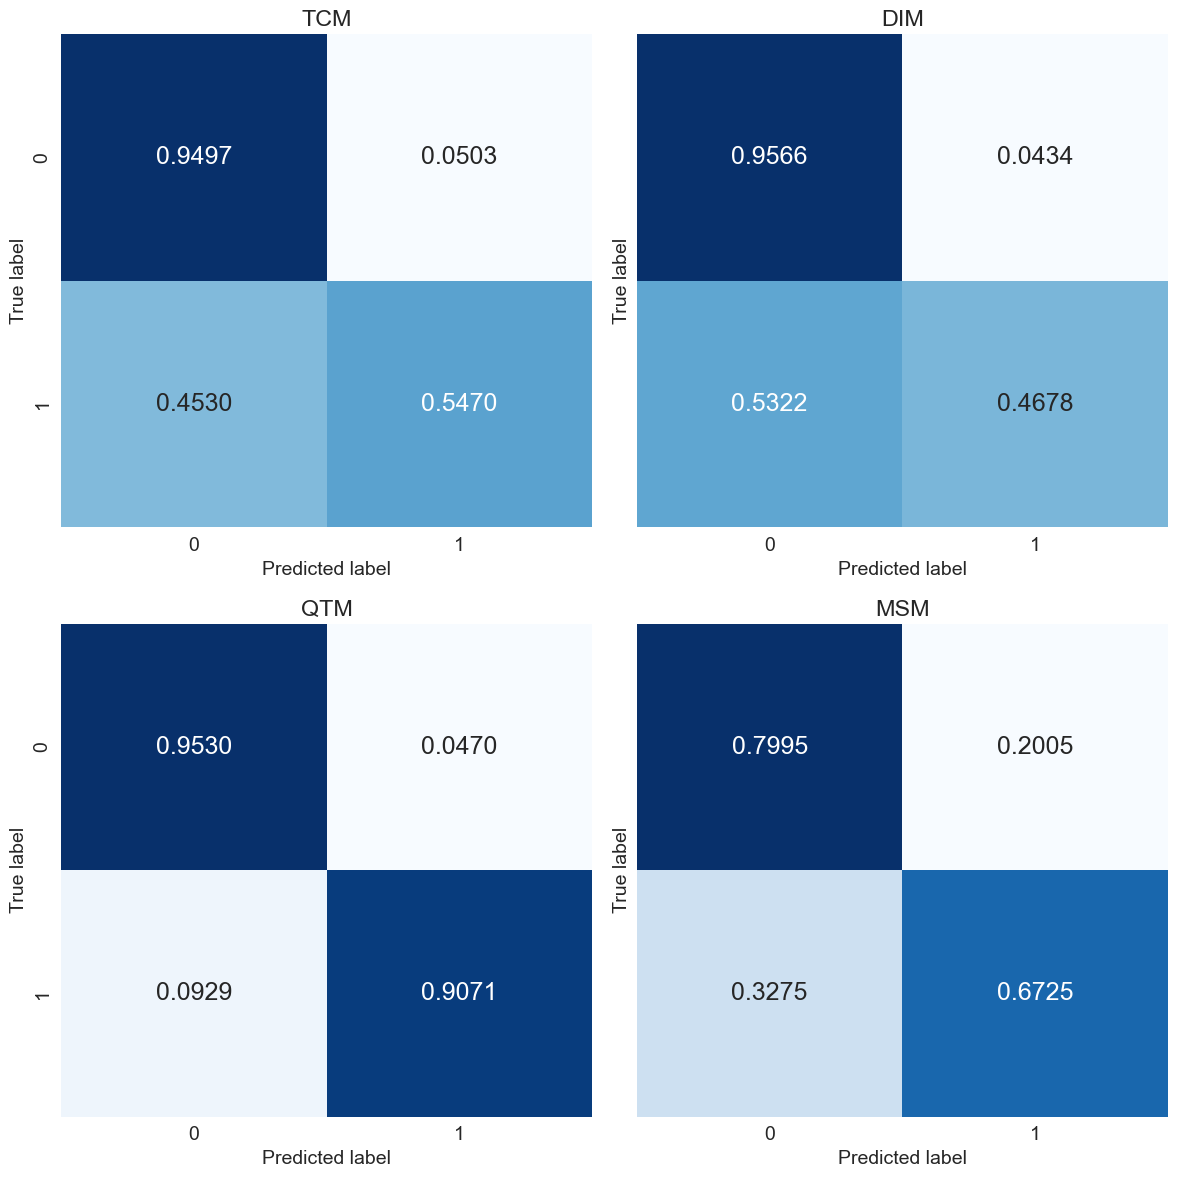

In [53]:
# plot confusion matrix per data model

labels_names = ["TCM", "DIM", "QTM", "MSM"]

fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

unique_labels = list(np.unique(test_labels))

cms = []

for idx, label in enumerate(unique_labels):
    indices = np.where(test_labels == label)
    cm = confusion_matrix(test_y[indices], preds[-1][indices] > 0.5)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    cms.append(cm)

for i, (cm, label) in enumerate(zip(cms, labels_names)):
    plot_confusion_matrix(ax.flatten()[i], cm, label)

plt.tight_layout()
plt.savefig(os.path.join("..", "figures", "confusion_matrices.pdf"))
plt.show()

In [54]:
label_metrics = {
    "accuracy": accuracy_score,
    "f1_score": f1_score,
    "recall": recall_score,
    "precision": precision_score,
}

In [55]:
def get_results_table_per_label(preds, test_y, test_labels, label_metrics):
    results = {}
    for label in unique_labels:
        results[label] = {}
        indices = np.where(test_labels == label)
        for metric_name, metric in label_metrics.items():
            results[label][metric_name] = metric(
                test_y[indices], np.round(preds[-1][indices])
            )
    return pd.DataFrame(results)

In [56]:
print(
    get_results_table_per_label(preds, test_y, test_labels, label_metrics).T.to_latex()
)

\begin{tabular}{lrrrr}
\toprule
 & accuracy & f1_score & recall & precision \\
\midrule
confinemnet & 0.813325 & 0.664892 & 0.546993 & 0.847579 \\
dimmerization & 0.794768 & 0.601506 & 0.467801 & 0.842225 \\
immobile & 0.937722 & 0.906547 & 0.907118 & 0.905977 \\
multi_state & 0.735929 & 0.718300 & 0.672504 & 0.770790 \\
\bottomrule
\end{tabular}



In [57]:
windows = [10, 20]
other_models = [
    load_model(os.path.join("..", "models", f"cnn_lstm_attention_{window}.keras"))
    for window in windows
]
other_histories = [
    json.load(
        open(os.path.join(path, f"cnn_lstm_attention_{window}_training_results.json"))
    )
    for window in windows
]

In [58]:
test_Xs = [
    np.load(os.path.join("..", "data", "classifier", f"{window}", "test", "X_test.npy"))
    for window in windows
]
test_ys = [
    np.load(os.path.join("..", "data", "classifier", f"{window}", "test", "y_test.npy"))
    for window in windows
]
test_datasets = [
    tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(32)
    for test_X, test_y in zip(test_Xs, test_ys)
]
test_labels_ = [
    np.load(
        os.path.join("..", "data", "classifier", f"{window}", "test", "labels_test.npy")
    )
    for window in windows
]
unique_labels = [np.unique(test_labels) for test_labels in test_labels_][0]

In [59]:
preds_other = [
    model.predict(test_dataset)
    for model, test_dataset in zip(other_models, test_datasets)
]

6459/6459 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step
6775/6775 ━━━━━━━━━━━━━━━━━━━━ 96s 14ms/step


In [60]:
def get_results_table_per_label_other(preds, test_y, test_labels, label_metrics):
    results = {}
    for label in unique_labels:
        results[label] = {}
        indices = np.where(test_labels == label)
        for metric_name, metric in label_metrics.items():
            results[label][metric_name] = metric(
                test_y[indices], np.round(preds[indices])
            )
    return pd.DataFrame(results)

In [61]:
print(
    get_results_table_per_label_other(
        preds_other[0], test_ys[0], test_labels_[0], label_metrics
    ).T.to_latex()
)

\begin{tabular}{lrrrr}
\toprule
 & accuracy & f1_score & recall & precision \\
\midrule
confinemnet & 0.772352 & 0.520934 & 0.371240 & 0.872919 \\
dimmerization & 0.763068 & 0.491799 & 0.343353 & 0.866366 \\
immobile & 0.927687 & 0.885422 & 0.847111 & 0.927362 \\
multi_state & 0.692005 & 0.515784 & 0.400698 & 0.723618 \\
\bottomrule
\end{tabular}



In [62]:
print(
    get_results_table_per_label_other(
        preds_other[1], test_ys[1], test_labels_[1], label_metrics
    ).T.to_latex()
)

\begin{tabular}{lrrrr}
\toprule
 & accuracy & f1_score & recall & precision \\
\midrule
confinemnet & 0.849372 & 0.743583 & 0.645144 & 0.877471 \\
dimmerization & 0.833123 & 0.694007 & 0.570815 & 0.885005 \\
immobile & 0.948868 & 0.923498 & 0.928025 & 0.919015 \\
multi_state & 0.773843 & 0.750836 & 0.682026 & 0.835088 \\
\bottomrule
\end{tabular}



In [70]:
def plot_other_histories(history_dict, window_length):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    loss = history_dict["loss"]
    val_loss = history_dict["val_loss"]
    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    N = len(loss)
    ax[0].plot(loss, label="Training", linestyle="-", c=colors[1])
    ax[0].plot(val_loss, label="Validation", linestyle="--", c=colors[2])
    ax[0].legend(title="Dataset")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_xticks(np.arange(N), np.arange(1, N + 1))

    ax[1].plot(acc, label="Training", linestyle="-", c=colors[1])
    ax[1].plot(val_acc, label="Validation", linestyle="--", c=colors[2])
    ax[1].legend(title="Dataset")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xticks(np.arange(N), np.arange(1, N + 1))
    # plt.suptitle(f"Window length: {window_length}", fontsize=20)
    plt.tight_layout()
    plt.savefig(
        os.path.join("..", "figures", f"other_training_results_{window_length}.pdf")
    )
    plt.show()

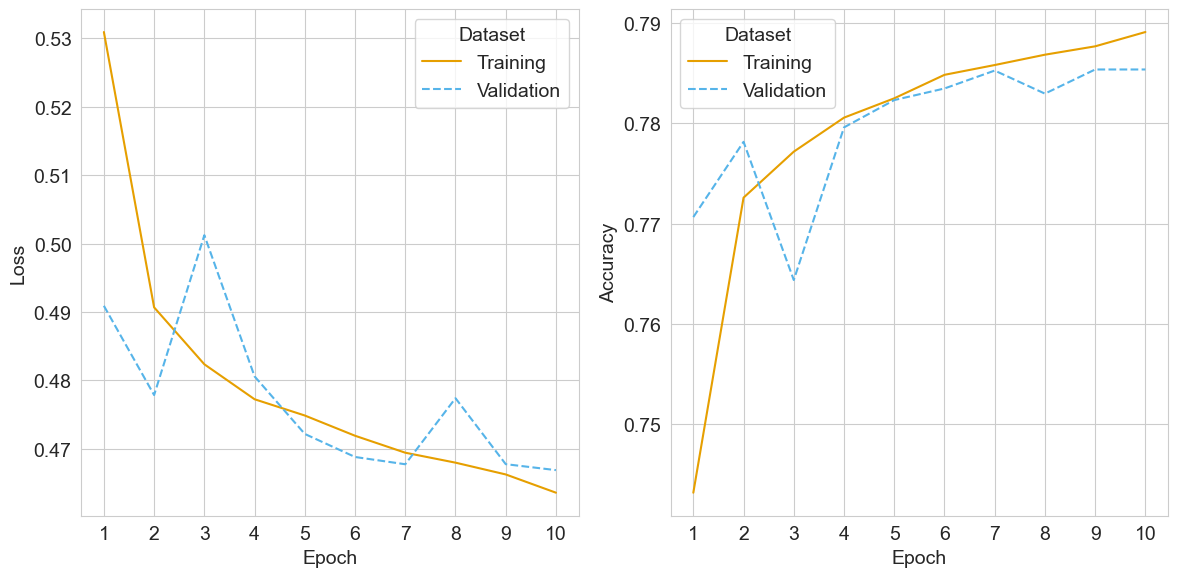

In [71]:
plot_other_histories(other_histories[0], 10)

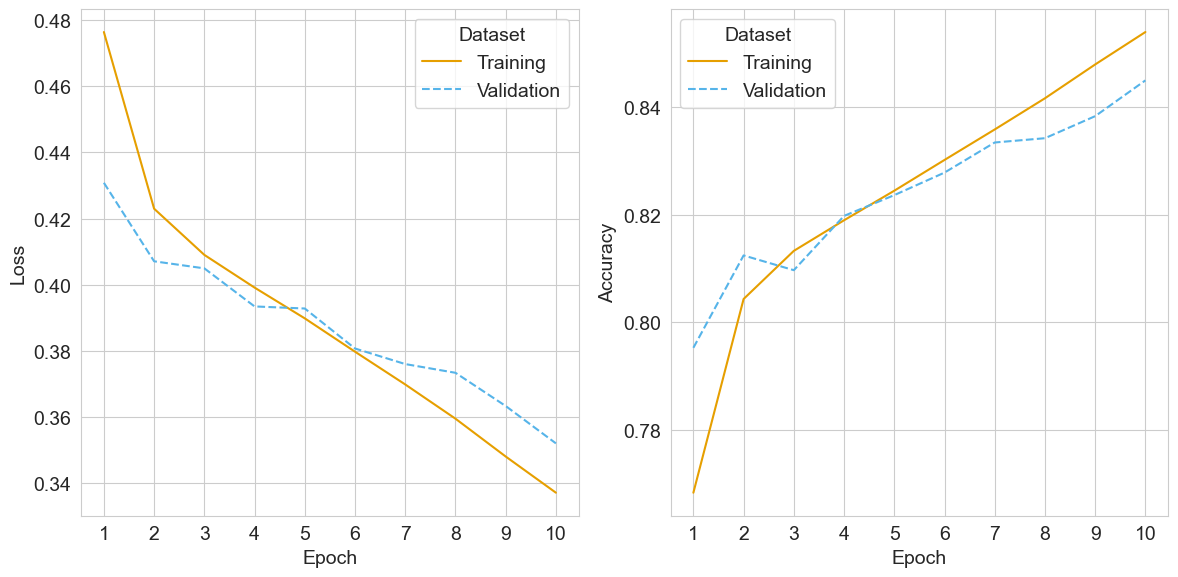

In [72]:
plot_other_histories(other_histories[1], 20)